In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio
!pip install geopandas

     |████████████████████████████████| 19.3 MB 1.3 MB/s 
     |████████████████████████████████| 1.0 MB 8.8 MB/s 
     |████████████████████████████████| 6.3 MB 37.3 MB/s 
     |████████████████████████████████| 15.4 MB 29.1 MB/s 


In [3]:
%pylab inline
import geopandas as gpd
import rasterio as rio
import rasterio.plot as rplot
import itertools

Populating the interactive namespace from numpy and matplotlib


In [4]:
# mounds_f = "MARS-Dataset/training_site/mapping/polygons/mounds.shp"
# dem_f = "MARS-Dataset/training_site/DEM/Low-res_DEM/Firsoff_HiRISE_5.tif-adj.tif"
# vents_f = "MARS-Dataset/training_site/mapping/points/vent_points.shp"

In [5]:
dem_path = '/content/drive/My Drive/Image Segmentation/'
dem_f = dem_path + "high_dem_filled.tif"
mounds_f = dem_path + "polygons/mounds.shp"
vents_f = dem_path + "points/vent_points.shp"

In [6]:
data = gpd.read_file(mounds_f)

toremove = []
for id, gg in enumerate(data.geometry):
    if not gg.is_valid:
        print(f"not valid {id}")
        toremove.append(id)

data = data.drop(toremove)
data.drop_duplicates(inplace=True)

vents = gpd.read_file(vents_f)



not valid 56
not valid 92
not valid 100
not valid 163
not valid 200
not valid 329
not valid 330


In [7]:
#Simple Mounds
simple_mounds = data[data.Morpho == "simple"]

PROJCS["Mars_Sinusoidal",GEOGCS["GCS_Mars_Sphere",DATUM["D_Mars_Sphere",SPHEROID["Mars_Sphere",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",350],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


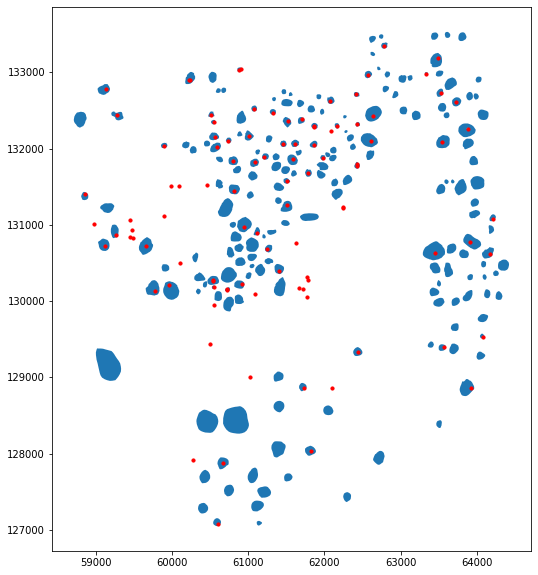

In [8]:
print(simple_mounds.crs)
figure(figsize = (10,10))
simple_mounds.plot(ax=gca())
vents.plot(ax=gca(), color = "red", markersize=10)

In [9]:
dem_source = rio.open(dem_f)
dtm = dem_source.read()
meta = dem_source.meta

In [10]:
dtm

array([[[-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        ...,
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.]]],
      dtype=float32)

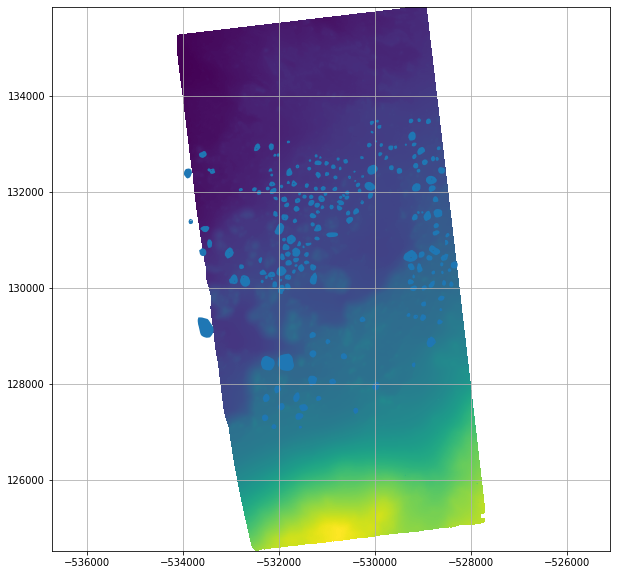

In [11]:
figure(figsize=(10,10))
axis("equal")
rplot.show(dem_source, ax=gca())
data_ = simple_mounds.to_crs(meta["crs"])
data_.plot(ax=gca(), column = "Morpho")

grid()

In [12]:
# dem_source.nodatavals

In [13]:
# mask = dem_source.read_masks(1)

In [14]:
# mask

In [15]:
import rasterio.mask as mask

In [16]:
import shutil

tmp = shutil.copy(dem_f, "tmp.tif")
src = rio.open(tmp, mode="r+")
src.write_mask(True)
src.read_masks(1).all()
src.close()

In [17]:
src = rio.open("tmp.tif")


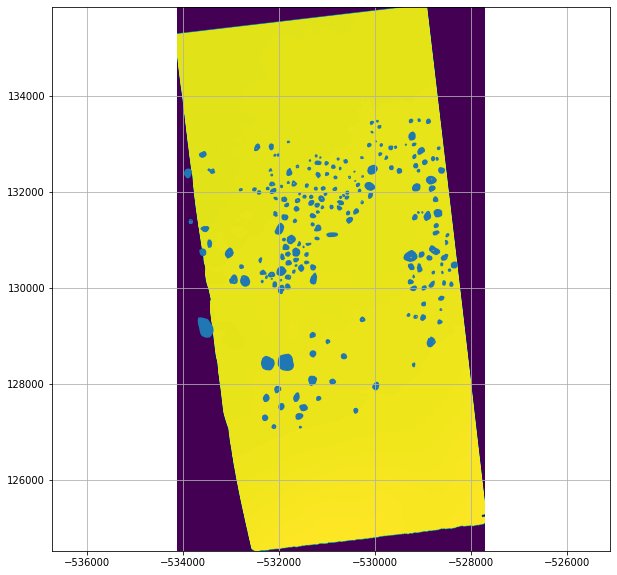

In [18]:
figure(figsize=(10,10))
# imshow(src, interpolation=None)
axis("equal")
rplot.show(src, ax=gca())
data_ = simple_mounds.to_crs(meta["crs"])
data_.plot(ax=gca(), column = "Morpho")

grid()

In [19]:
src.transform

Affine(1.0, 0.0, -534126.5,
       0.0, -1.0, 135856.5)

In [20]:
mounds_enlarged = []
for i, geometry in enumerate(data_.geometry):
    enlarged = geometry.buffer(2)
    from shapely.geometry import Polygon
    pp = Polygon.from_bounds(*geometry.bounds)
    
    out_img, out_transform = mask.mask(dataset=dem_source, shapes=[enlarged], nodata=np.nan, crop=True, all_touched=True, filled=True, pad=False)
    
    mounds_enlarged.append((out_img[0], i))
    
    # if np.any(np.isnan(out_img)):
    #     print(f"{i} has nans")
    #     continue

In [21]:
for mound, mound_id in mounds_enlarged:
    figure()
    imshow(mound)
    title(f"id {mound_id}")
    # plt.savefig('{0:s}_interp.png'.format(dem_path+"Enlarged Mounds/"+str(mound_id)), dpi=100)

Output hidden; open in https://colab.research.google.com to view.

In [24]:
from scipy.interpolate import griddata

In [25]:
def make_interpolated_image(nsamples, im, method ="linear"):
    """Make an interpolated image from a random selection of pixels.

    Take nsamples random pixels from im and reconstruct the image using
    scipy.interpolate.griddata.

    """

    ix = np.random.randint(im.shape[1], size=nsamples)
    iy = np.random.randint(im.shape[0], size=nsamples)
    samples = im[iy,ix]
    int_im = griddata((iy, ix), samples, (Y, X), method=method)
    return int_im

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


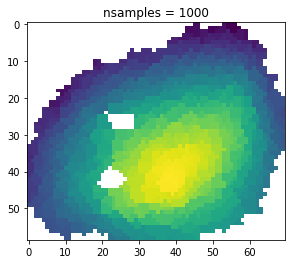

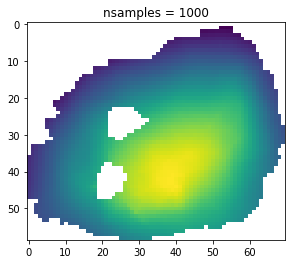

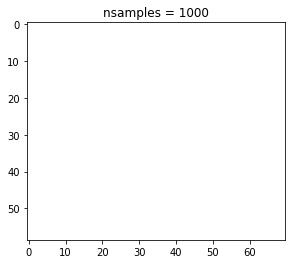

In [26]:
for mound, mound_id in mounds_enlarged:
    # A meshgrid of pixel coordinates
    nx, ny = mound.data.shape[1], mound.data.shape[0]
    X, Y = np.meshgrid(np.arange(0, nx, 1), np.arange(0, ny, 1))
    methods=["nearest", "linear", "cubic"]

    # images in the figure
    nsamples = 1000
    if mound_id ==7:
      for method in methods:
        figure()
        imshow(make_interpolated_image(nsamples, mound, method))
        title('nsamples = {0:d}'.format(nsamples))
#     filestem = os.path.splitext(os.path.basename(img_name))[0]
#     plt.savefig('{0:s}_interp.png'.format(filestem), dpi=100)